In [ ]:
#
# 
# https://towardsdatascience.com/a-fresh-look-at-clustering-algorithms-c3c4caa1a691

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.backend='seaborn'
import time
import itertools

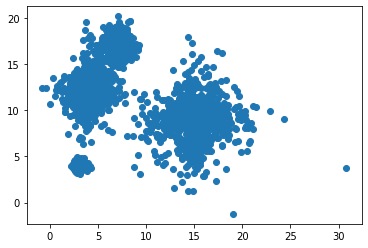

In [4]:
# Create the data
ttf=pd.DataFrame(
    {
        'x':np.concatenate(
            (
                3 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000) / 3,
                15 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000) *3 ,
                7 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000),
                4 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000) * 1.5
            )
        ),
        'y':np.concatenate(
            (
                4 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000)/3,
                9 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000)*3,
                17 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000),
                12 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000) * 2
            )
        )
    }
)
plt.scatter(ttf.x,ttf.y)
plt.show()

In [5]:
#normalise dataset
ttf_norm = ttf.copy()
ttf_norm['x'] = (
    ttf['x'] - np.min(ttf.x)
) / (
    np.max(ttf.x) - np.min(ttf.x)
)
ttf_norm['y'] = (
    ttf['y'] - np.min(ttf.y)
) / (
    np.max(ttf.y) - np.min(ttf.y)
)

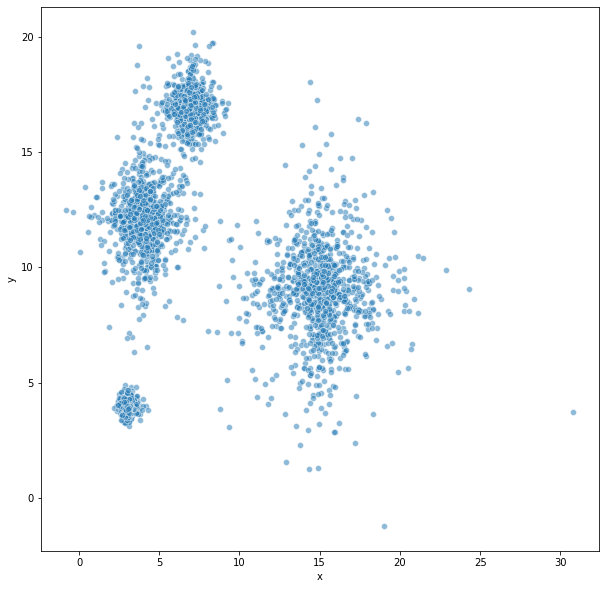

In [6]:
plt.figure(figsize=(10, 10))
sns.scatterplot(ttf.x, ttf.y, alpha=0.5)

In [9]:
# count number of cells
D = int(np.sqrt(len(ttf_norm)))
tolerance = 90
X = ttf_norm[['x', 'y']].values
# SCale and discretise
Xint = (X * D).astype(int)

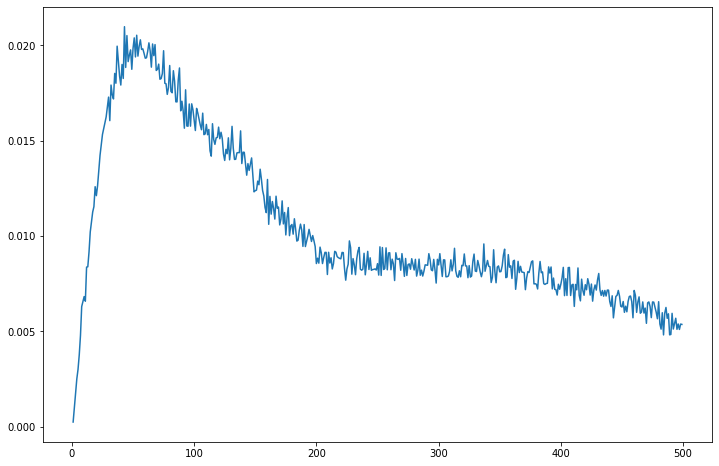

In [8]:
prop=[]
for d in range(1, 500):
    Xint = (X * d).astype(int)
    unique, counts = np.unique(Xint, axis=0, return_counts=True)
    prop.append(
        len(
            counts[counts > 10]
        )/(
            len(
                counts[counts == 1]
            ) + len(Xint) - len(unique)
        )
    )
    
plt.figure(figsize=(12, 8))
plt.plot(list(range(1, 500)), prop)    
    

In [18]:
Xint

array([[ 8, 14],
       [ 7, 16],
       [ 7, 14],
       ...,
       [10, 41],
       [ 5, 38],
       [ 4, 33]])

In [11]:
#copied code



def cell_cluster(Xint, D, tolerance=70):
    
    # Identify unique cells, with corresponding element counts
    unique, counts = np.unique(Xint, axis=0, return_counts=True)

    #calculate the threshold, corresponding to our tolerance
    mincount = int(
        np.percentile(
            counts[
                counts >1
            ],
            tolerance
        )
    )

  
    # reduce the array of elements to unique elements with counts over 
    # the threshold.
    allids = unique[counts > mincount]
    
    # run the function identifying the clusters of unit cells.
    clusters = find_trees(allids, D)
    
   
    return clusters
  

def find_trees(allids, D):
    # Function for counting unconnected trees.
    # Takes in the collection of identified cells above threshold (allids)
    # and the critical divisions parameter we defined at the start.
    # Returns a dictionary of clusters, with interger IDs as keys 
    # (assigned in order of passing trough)
    # and arrays of corresponding values
    
    
    len_ids=len(allids) #length of input array of elements, needed for status udates
    
    tocheck = np.array([]) # Array of neighbour ids set aside for checking
    
    clusters = dict() #output dictionary.
    clusterid = 0 # counter for identified clusters
    
    
    while len(allids) > 0:
        
        
        ids = allids[0]
        clusterid += 1
        allids = allids[1:]
        visited = ids # mark the current observation as visited
        
        # selecting nearest neighbours.
        # As we are dealing with integers in all dimensions
        # by design - setting the threshold to 1.
        # For some applications a higher number can be used here.
        mask = np.all(np.abs(allids-ids)<=1, axis=1)
        tch = allids[mask]
        allids = allids[~mask]
       
        if len(tch) > 0:
            
            tocheck = tch
            
            # Main loop - filling in the rest of the cluster
            
            while len(tocheck)>0:
                
                idsi = tocheck[0]
                tocheck = tocheck[1:]
                
                # mark as visited
                visited = np.vstack([visited, idsi])
                
                # get the neighbours
                mask = np.all(np.abs(allids-idsi)<=1, axis=1)
                nbrs = allids[mask]
                allids = allids[~mask]
                
                if len(nbrs) > 0:
                    tocheck = np.vstack([tocheck, nbrs])
                

                    
            # store all visited nodes into cluster dictionary.    
            clusters[clusterid] = visited   
           # clear_output(wait=True)
            print('Processed {:.2f}% ids'.format((len_ids-len(allids)) / len_ids * 100))
            print('{} clusters found'.format(len(clusters.keys())))       
    
    return clusters
  

def cluster_attribution(X, D, clusters):
    # For each element of X calculate the distance
    # to all identified cluster centroids
    # mark them with the id of nearest cluster.
    # technically only need to do this for unmarked
    # points, but we are doing it in vector form anyway,
    #so running through the entire X.
    yhat_ = np.sum(
                        (
                            X - np.average(
                                clusters[list(clusters.keys())[0]].astype(float),
                                axis=0
                            ) / D
                        ) ** 2,
                        axis=1
                )
    for i, k in enumerate(clusters.keys()):
        if i>0:
            yhat_ = np.vstack(
                [
                    yhat_,
                    np.sum(
                            (
                                X - np.average(
                                    clusters[k].astype(float),
                                    axis=0
                                ) / D
                            ) ** 2,
                            axis=1
                    )

                ]
            )
    yhat = np.argmin(yhat_.T, axis=1) + 1
    return yhat


def cluster_attribution_nearestneighbour(Xint, D, clusters):
    # Attributing points by finding the closest point
    # already assigned to a cluster. 
    
    #initiate the vector of outputs with zeros
    yhat = np.zeros(len(Xint))
    
    # iterate through clusters and mark up relevant points of yhat
    # result is cluster ids where identified and zeros where not
    for i, k in enumerate(clusters.keys()):
        yhat += (Xint[:, None] == clusters[k]).all(-1).any(-1) * k
    
    # calculate distances to all elements of all clusters and take min
    yhat_ = np.min(
                            np.sum(
                                (
                                    Xint[yhat == 0][:, None] - clusters[list(clusters.keys())[0]]
                                ) ** 2,
                                axis=-1
                            ),
                            axis=-1
                    )
    for i, k in enumerate(clusters.keys()):
        if i>0:
            yhat_ = np.vstack(
                [
                    yhat_,
                    np.min(
                            np.sum(
                                (
                                    Xint[yhat == 0][:, None] - clusters[k]
                                ) ** 2,
                                axis=-1
                            ),
                            axis=-1
                    )
                ]
            )
    # Mark up the unassigned elements of yhat
    yhat[yhat == 0] = np.take(
        np.array(
            list(clusters.keys())
        ),
        np.argmin(yhat_.T, axis=1).T
    )
    return yhat.astype(int)
 

def density_trees_fit(X, D, tolerance):
    # wrapper function - centroids
    Xint = (X * D).astype(int)
    clusters = cell_cluster(Xint, D, tolerance=tolerance)
    yhat = cluster_attribution(X, D, clusters)
    return yhat
  
def density_trees_fit_nn(X, D, tolerance):
  # wrapper function - nearest neighbour
    Xint = (X * D).astype(int)
    clusters = cell_cluster(Xint, D, tolerance=tolerance)
    yhat = cluster_attribution_nearestneighbour(Xint, D, clusters)
    return yhat

In [17]:
ttf_norm['trees'] = out
ttf_norm

,x,y,Affinity,trees
0,0.127373,0.229430,0,1
1,0.121155,0.256893,0,1
2,0.122025,0.236678,0,1
3,0.115817,0.249023,0,1
4,0.112116,0.261224,0,1
...,...,...,...,...
3995,0.179281,0.574606,21,2
3996,0.159072,0.639297,19,2
3997,0.163912,0.662001,24,2
3998,0.094003,0.608992,20,2


Processed 9.52% ids
1 clusters found
Processed 44.76% ids
2 clusters found
Processed 73.33% ids
3 clusters found
Processed 99.05% ids
4 clusters found


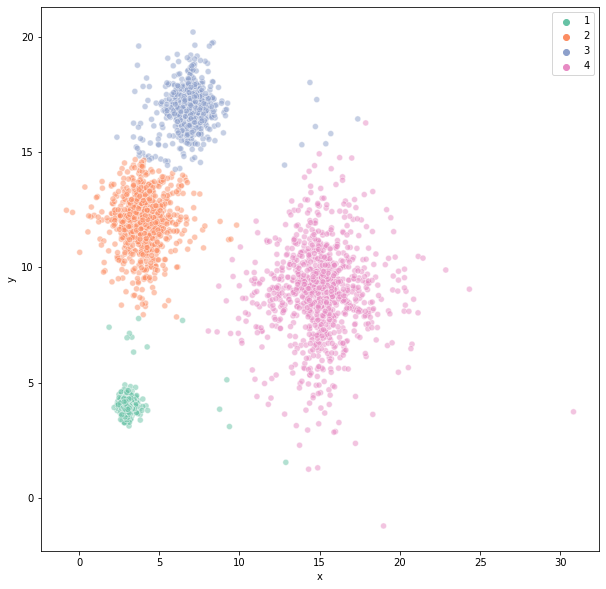

In [12]:
out = density_trees_fit(X,D,tolerance)
plt.figure(figsize=(10, 10))
sns.scatterplot(ttf.x, ttf.y, alpha=0.5, hue = out,palette="Set2")


In [14]:
import sklearn
from sklearn.cluster import AffinityPropagation
model = AffinityPropagation(damping=0.9)
#%%time
model.fit(X)
ttf_norm['Affinity'] = model.predict(X)


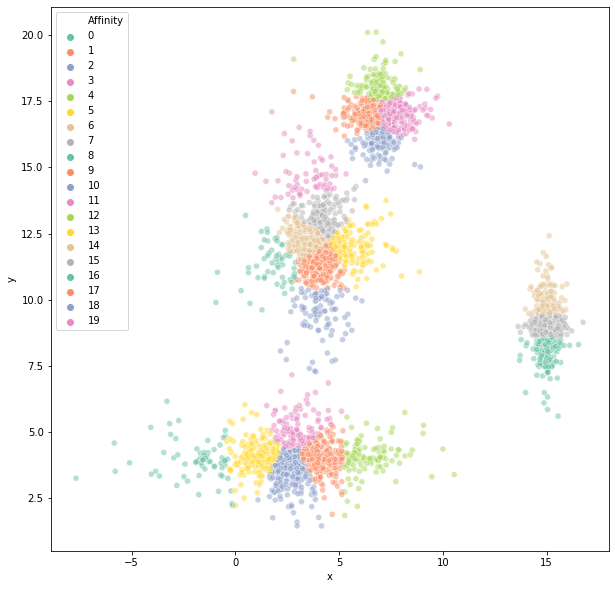

In [81]:
plt.figure(figsize=(10, 10))
sns.scatterplot(ttf.x, ttf.y, alpha=0.5, hue = ttf_norm.Affinity,palette="Set2")

In [85]:
ttf_norm


,x,y,Affinity
0,0.403613,0.054289,2
1,0.499547,0.117719,5
2,0.610836,0.135909,7
3,0.240559,0.131216,4
4,0.465935,0.123485,5
...,...,...,...
3995,0.450356,0.405691,19
3996,0.480408,0.522116,18
3997,0.461608,0.798855,21
3998,0.468782,0.505873,18


Processed 33.33% ids
1 clusters found
Processed 59.52% ids
2 clusters found
Processed 84.29% ids
3 clusters found
Processed 100.00% ids
4 clusters found


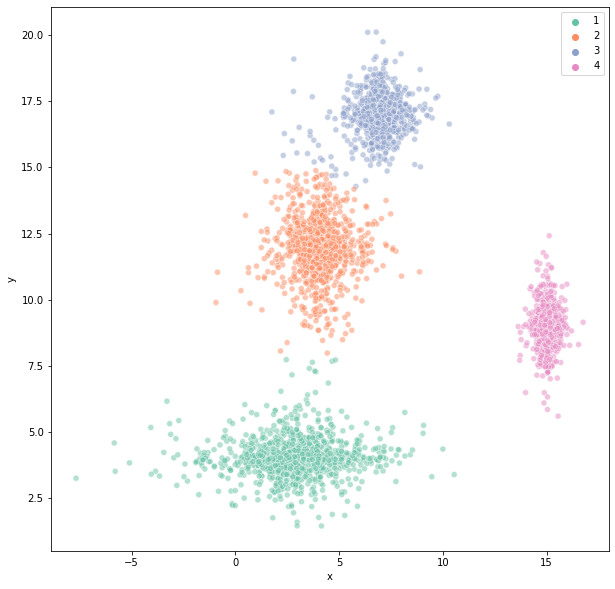